In [2]:
from nuscenes.nuscenes import NuScenes
from PIL import Image
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix
import json
import math
import os
import os.path as osp
import sys
import time
from datetime import datetime
from typing import Tuple, List, Iterable

import cv2
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
from PIL import Image
from matplotlib import rcParams
from matplotlib.axes import Axes
from pyquaternion import Quaternion
from tqdm import tqdm

import cv2
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
from PIL import Image
from matplotlib import rcParams
from matplotlib.axes import Axes
from pyquaternion import Quaternion
from tqdm import tqdm

from nuscenes.lidarseg.lidarseg_utils import colormap_to_colors, plt_to_cv2, get_stats, \
    get_labels_in_coloring, create_lidarseg_legend, paint_points_label
from nuscenes.panoptic.panoptic_utils import paint_panop_points_label, stuff_cat_ids, get_frame_panoptic_instances,\
    get_panoptic_instances_stats
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud, Box
from nuscenes.utils.data_io import load_bin_file, panoptic_to_lidarseg
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix
from nuscenes.utils.map_mask import MapMask
from nuscenes.utils.color_map import get_colormap
nusc = NuScenes(version='v1.0-mini', dataroot='../data/nuscenes', verbose=True)
#with open('../center_overlap.txt', 'r') as f:
#    anns2 = [each.strip() for each in f.readlines()]


Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.632 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [13]:
nusc.get('sample_annotation', anns[12])

{'token': '0d5ecc64875b4c449644820e90cf370c',
 'sample_token': '39586f9d59004284a7114a68825e8eec',
 'instance_token': '2ce122b054384340a99b146634f3c4da',
 'visibility_token': '4',
 'attribute_tokens': [],
 'translation': [401.265, 1173.449, 0.482],
 'size': [0.476, 0.461, 0.72],
 'rotation': [0.8176174735138021, 0.0, 0.0, -0.5757618144727099],
 'prev': 'ffeafb90ecd5429cba23d0be9a5b54ee',
 'next': 'aff62b29d7ee4e2a90c1138c1657e315',
 'num_lidar_pts': 14,
 'num_radar_pts': 0,
 'category_name': 'movable_object.trafficcone'}

In [2]:
from nuscenes.utils.splits import val
val

['scene-0003',
 'scene-0012',
 'scene-0013',
 'scene-0014',
 'scene-0015',
 'scene-0016',
 'scene-0017',
 'scene-0018',
 'scene-0035',
 'scene-0036',
 'scene-0038',
 'scene-0039',
 'scene-0092',
 'scene-0093',
 'scene-0094',
 'scene-0095',
 'scene-0096',
 'scene-0097',
 'scene-0098',
 'scene-0099',
 'scene-0100',
 'scene-0101',
 'scene-0102',
 'scene-0103',
 'scene-0104',
 'scene-0105',
 'scene-0106',
 'scene-0107',
 'scene-0108',
 'scene-0109',
 'scene-0110',
 'scene-0221',
 'scene-0268',
 'scene-0269',
 'scene-0270',
 'scene-0271',
 'scene-0272',
 'scene-0273',
 'scene-0274',
 'scene-0275',
 'scene-0276',
 'scene-0277',
 'scene-0278',
 'scene-0329',
 'scene-0330',
 'scene-0331',
 'scene-0332',
 'scene-0344',
 'scene-0345',
 'scene-0346',
 'scene-0519',
 'scene-0520',
 'scene-0521',
 'scene-0522',
 'scene-0523',
 'scene-0524',
 'scene-0552',
 'scene-0553',
 'scene-0554',
 'scene-0555',
 'scene-0556',
 'scene-0557',
 'scene-0558',
 'scene-0559',
 'scene-0560',
 'scene-0561',
 'scene-05

In [23]:
ann_record = nusc.get('sample_annotation',anns[12])

In [32]:
sample_record = nusc.get('sample', ann_record['sample_token'])
sample_record
nusc.render_scene(sample_record['scene_token'])

In [12]:
cams = ['CAM_FRONT',
 'CAM_FRONT_RIGHT',
 'CAM_BACK_RIGHT',
 'CAM_BACK',
 'CAM_BACK_LEFT',
 'CAM_FRONT_LEFT']

In [20]:

show =False
for ann in anns:
    all_bboxes = 0
    for cam in cams:
        _, boxes, _ = nusc.get_sample_data(sample_record['data'][cam], box_vis_level=BoxVisibility.ANY,
                                                        selected_anntokens=[ann])
        if len(boxes)>0:
            all_bboxes+=1
        if all_bboxes>1:
            show=True
            nusc.render_annotation(ann)
        if show:
            break
    if show:
        break


NameError: name 'anns' is not defined

In [4]:
scenes = nusc.scene[0]
scenes


{'token': 'cc8c0bf57f984915a77078b10eb33198',
 'log_token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
 'nbr_samples': 39,
 'first_sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'last_sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
 'name': 'scene-0061',
 'description': 'Parked truck, construction, intersection, turn left, following a van'}

In [29]:
overlap = 0
all = 0
anns = []
for scene in nusc.scene:
        sample = nusc.get('sample', scene['first_sample_token'])
        while True:
                for ann in sample['anns']:
                        boxes_count = 0
                        for cam in cams:
                                
                                _, boxes, _ = get_sample_data(sample['data'][cam], box_vis_level=BoxVisibility.ANY,
                                                        selected_anntokens=[ann])
                                if len(boxes)>0:
                                        boxes_count+=1
                        if boxes_count>1:
                                overlap+=1
                                anns.append(ann)
                        all+=1
                if sample['next'] != '':
                        sample = nusc.get('sample', sample['next'])
                else:
                        break
                break
        #for data in nusc.list_sample(sample['token']):
        #    print(data)

cams ['ad35067545a24e72989c965d3a84afe7', 'e7658070b2f94ab588f19ad52f4ab5ab']
1
2


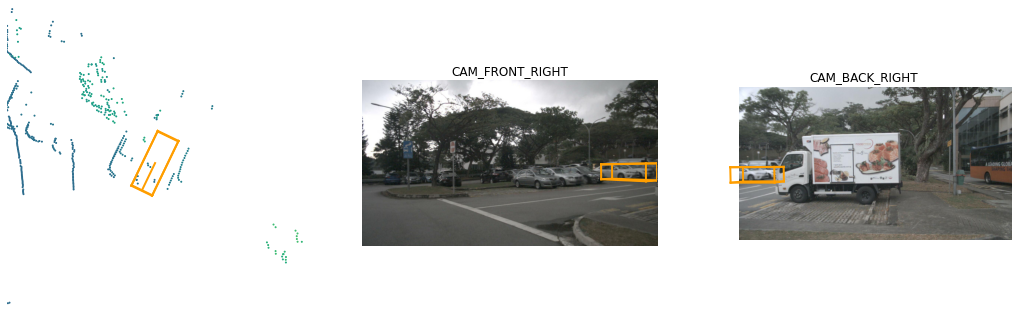

In [37]:

render_annotation(anns2[180])

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud, Box
from PIL import Image
from matplotlib import rcParams
def get_color(category_name: str):
        """
        Provides the default colors based on the category names.
        This method works for the general nuScenes categories, as well as the nuScenes detection categories.
        """

        return nusc.colormap[category_name]
def render_annotation(
                          anntoken: str,
                          margin: float = 10,
                          view: np.ndarray = np.eye(4),
                          box_vis_level: BoxVisibility = BoxVisibility.ANY,
                          out_path: str = None,
                          extra_info: bool = False) -> None:
        """
        Render selected annotation.
        :param anntoken: Sample_annotation token.
        :param margin: How many meters in each direction to include in LIDAR view.
        :param view: LIDAR view point.
        :param box_vis_level: If sample_data is an image, this sets required visibility for boxes.
        :param out_path: Optional path to save the rendered figure to disk.
        :param extra_info: Whether to render extra information below camera view.
        """
        ann_record = nusc.get('sample_annotation', anntoken)
        sample_record = nusc.get('sample', ann_record['sample_token'])
        assert 'LIDAR_TOP' in sample_record['data'].keys(), 'Error: No LIDAR_TOP in data, unable to render.'

        

        # Figure out which camera the object is fully visible in (this may return nothing).
        boxes, cam = [], []
        cams = [key for key in sample_record['data'].keys() if 'CAM' in key]
        all_bboxes = []
        select_cams = []
        for cam in cams:
            _, boxes, _ = nusc.get_sample_data(sample_record['data'][cam], box_vis_level=box_vis_level,
                                                    selected_anntokens=[anntoken])
            if len(boxes) > 0:
                all_bboxes.append(boxes)
                select_cams.append(cam)
                # We found an image that matches. Let's abort.
        #assert len(boxes) > 0, 'Error: Could not find image where annotation is visible. ' \
         #                      'Try using e.g. BoxVisibility.ANY.'
        #assert len(boxes) < 2, 'Error: Found multiple annotations. Something is wrong!'
        
        num_cam = len(all_bboxes)

        fig, axes = plt.subplots(1, num_cam+1, figsize=(18, 9))
        select_cams = [sample_record['data'][cam] for cam in select_cams]
        print('cams', select_cams)
        # Plot LIDAR view.
        lidar = sample_record['data']['LIDAR_TOP']
        data_path, boxes, camera_intrinsic = nusc.get_sample_data(lidar, selected_anntokens=[anntoken])
        LidarPointCloud.from_file(data_path).render_height(axes[0], view=view)
        for box in boxes:
            c = np.array(get_color(box.name)) / 255.0
            box.render(axes[0], view=view, colors=(c, c, c))
            corners = view_points(boxes[0].corners(), view, False)[:2, :]
            axes[0].set_xlim([np.min(corners[0, :]) - margin, np.max(corners[0, :]) + margin])
            axes[0].set_ylim([np.min(corners[1, :]) - margin, np.max(corners[1, :]) + margin])
            axes[0].axis('off')
            axes[0].set_aspect('equal')

        # Plot CAMERA view.
        for i in range(1, num_cam+1):
            print(i)
            cam = select_cams[i-1]
            data_path, boxes, camera_intrinsic = nusc.get_sample_data(cam, selected_anntokens=[anntoken])
            im = Image.open(data_path)
            axes[i].imshow(im)
            axes[i].set_title(nusc.get('sample_data', cam)['channel'])
            axes[i].axis('off')
            axes[i].set_aspect('equal')
            for box in boxes:
                c = np.array(get_color(box.name)) / 255.0
                box.render(axes[i], view=camera_intrinsic, normalize=True, colors=(c, c, c))

            # Print extra information about the annotation below the camera view.
        if extra_info:
            rcParams['font.family'] = 'monospace'

            w, l, h = ann_record['size']
            category = ann_record['category_name']
            lidar_points = ann_record['num_lidar_pts']
            radar_points = ann_record['num_radar_pts']

            sample_data_record = nusc.get('sample_data', sample_record['data']['LIDAR_TOP'])
            pose_record = nusc.get('ego_pose', sample_data_record['ego_pose_token'])
            dist = np.linalg.norm(np.array(pose_record['translation']) - np.array(ann_record['translation']))

            information = ' \n'.join(['category: {}'.format(category),
                                      '',
                                      '# lidar points: {0:>4}'.format(lidar_points),
                                      '# radar points: {0:>4}'.format(radar_points),
                                      '',
                                      'distance: {:>7.3f}m'.format(dist),
                                      '',
                                      'width:  {:>7.3f}m'.format(w),
                                      'length: {:>7.3f}m'.format(l),
                                      'height: {:>7.3f}m'.format(h)])

            plt.annotate(information, (0, 0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top')

        if out_path is not None:
            plt.savefig(out_path)

In [111]:
nusc.scene[0]

{'token': 'cc8c0bf57f984915a77078b10eb33198',
 'log_token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
 'nbr_samples': 39,
 'first_sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'last_sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
 'name': 'scene-0061',
 'description': 'Parked truck, construction, intersection, turn left, following a van'}

In [3]:
from pyquaternion import Quaternion
def get_sample_data(sample_data_token: str,
                        box_vis_level: BoxVisibility = BoxVisibility.ANY,
                        selected_anntokens= None,
                        use_flat_vehicle_coordinates: bool = False):
        """
        Returns the data path as well as all annotations related to that sample_data.
        Note that the boxes are transformed into the current sensor's coordinate frame.
        :param sample_data_token: Sample_data token.
        :param box_vis_level: If sample_data is an image, this sets required visibility for boxes.
        :param selected_anntokens: If provided only return the selected annotation.
        :param use_flat_vehicle_coordinates: Instead of the current sensor's coordinate frame, use ego frame which is
                                             aligned to z-plane in the world.
        :return: (data_path, boxes, camera_intrinsic <np.array: 3, 3>)
        """

        # Retrieve sensor & pose records
        sd_record = nusc.get('sample_data', sample_data_token)
        cs_record = nusc.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
        sensor_record = nusc.get('sensor', cs_record['sensor_token'])
        pose_record = nusc.get('ego_pose', sd_record['ego_pose_token'])

        data_path = nusc.get_sample_data_path(sample_data_token)

        if sensor_record['modality'] == 'camera':
            cam_intrinsic = np.array(cs_record['camera_intrinsic'])
            imsize = (sd_record['width'], sd_record['height'])
        else:
            cam_intrinsic = None
            imsize = None

        # Retrieve all sample annotations and map to sensor coordinate system.
        if selected_anntokens is not None:
            boxes = list(map(nusc.get_box, selected_anntokens))
        else:
            boxes = nusc.get_boxes(sample_data_token)

        # Make list of Box objects including coord system transforms.
        box_list = []
        for box in boxes:
            if use_flat_vehicle_coordinates:
                # Move box to ego vehicle coord system parallel to world z plane.
                yaw = Quaternion(pose_record['rotation']).yaw_pitch_roll[0]
                box.translate(-np.array(pose_record['translation']))
                box.rotate(Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)]).inverse)
            else:
                # Move box to ego vehicle coord system.
                box.translate(-np.array(pose_record['translation']))
                box.rotate(Quaternion(pose_record['rotation']).inverse)

                #  Move box to sensor coord system.
                box.translate(-np.array(cs_record['translation']))
                box.rotate(Quaternion(cs_record['rotation']).inverse)
            
            if sensor_record['modality'] == 'camera' and not \
                    box_in_image(box, cam_intrinsic, imsize, vis_level=box_vis_level):
                continue

            box_list.append(box)

        return data_path, box_list, cam_intrinsic

In [4]:
from pyquaternion import Quaternion
def get_predicted_data(sample_data_token: str,
                        box_vis_level: BoxVisibility = BoxVisibility.ANY,
                        selected_anntokens= None,
                        use_flat_vehicle_coordinates: bool = False,
                        pred_anns =None
                        ):
        """
        Returns the data path as well as all annotations related to that sample_data.
        Note that the boxes are transformed into the current sensor's coordinate frame.
        :param sample_data_token: Sample_data token.
        :param box_vis_level: If sample_data is an image, this sets required visibility for boxes.
        :param selected_anntokens: If provided only return the selected annotation.
        :param use_flat_vehicle_coordinates: Instead of the current sensor's coordinate frame, use ego frame which is
                                             aligned to z-plane in the world.
        :return: (data_path, boxes, camera_intrinsic <np.array: 3, 3>)
        """

        # Retrieve sensor & pose records
        sd_record = nusc.get('sample_data', sample_data_token)
        cs_record = nusc.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
        sensor_record = nusc.get('sensor', cs_record['sensor_token'])
        pose_record = nusc.get('ego_pose', sd_record['ego_pose_token'])

        data_path = nusc.get_sample_data_path(sample_data_token)

        if sensor_record['modality'] == 'camera':
            cam_intrinsic = np.array(cs_record['camera_intrinsic'])
            imsize = (sd_record['width'], sd_record['height'])
        else:
            cam_intrinsic = None
            imsize = None

        # Retrieve all sample annotations and map to sensor coordinate system.
        #if selected_anntokens is not None:
        #    boxes = list(map(nusc.get_box, selected_anntokens))
        #else:
        #    boxes = nusc.get_boxes(sample_data_token)
        boxes = pred_anns
        # Make list of Box objects including coord system transforms.
        box_list = []
        for box in boxes:
            if use_flat_vehicle_coordinates:
                # Move box to ego vehicle coord system parallel to world z plane.
                yaw = Quaternion(pose_record['rotation']).yaw_pitch_roll[0]
                box.translate(-np.array(pose_record['translation']))
                box.rotate(Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)]).inverse)
            else:
                # Move box to ego vehicle coord system.
                box.translate(-np.array(pose_record['translation']))
                box.rotate(Quaternion(pose_record['rotation']).inverse)

                #  Move box to sensor coord system.
                box.translate(-np.array(cs_record['translation']))
                box.rotate(Quaternion(cs_record['rotation']).inverse)
            
            if sensor_record['modality'] == 'camera' and not \
                    box_in_image(box, cam_intrinsic, imsize, vis_level=box_vis_level):
                continue

            box_list.append(box)

        return data_path, box_list, cam_intrinsic

In [5]:
from nuscenes.lidarseg.lidarseg_utils import colormap_to_colors, plt_to_cv2, get_stats, \
    get_labels_in_coloring, create_lidarseg_legend, paint_points_label
import os.path as osp
import os
from nuscenes.panoptic.panoptic_utils import paint_panop_points_label, stuff_cat_ids, get_frame_panoptic_instances,\
    get_panoptic_instances_stats
from nuscenes.eval.common.data_classes import EvalBoxes, EvalBox
from nuscenes.eval.detection.data_classes import DetectionBox
from nuscenes.eval.detection.utils import category_to_detection_name
from nuscenes.eval.detection.render import visualize_sample

def lidiar_render(sample_token,data):
    bbox_gt_list = []
    bbox_pred_list = []
    anns = nusc.get('sample',sample_token)['anns']
    for ann in anns:
        content =  nusc.get('sample_annotation', ann)
        try:
            bbox_gt_list.append(DetectionBox(
                sample_token=content['sample_token'],
                translation=tuple(content['translation']),
                size=tuple(content['size']),
                rotation=tuple(content['rotation']),
                velocity=nusc.box_velocity(content['token'])[:2],
                ego_translation=(0.0, 0.0, 0.0) if 'ego_translation' not in content
                else tuple(content['ego_translation']),
                num_pts=-1 if 'num_pts' not in content else int(content['num_pts']),
                detection_name =  category_to_detection_name(content['category_name']),
                detection_score=-1.0 if 'detection_score' not in content else float(content['detection_score']),
                attribute_name=''))
        except:
            pass

    bbox_anns = data['results'][sample_token] 
    for content in bbox_anns:
        bbox_pred_list.append(DetectionBox(
                sample_token=content['sample_token'],
                translation=tuple(content['translation']),
                size=tuple(content['size']),
                rotation=tuple(content['rotation']),
                velocity=tuple(content['velocity']),
                ego_translation=(0.0, 0.0, 0.0) if 'ego_translation' not in content
                else tuple(content['ego_translation']),
                num_pts=-1 if 'num_pts' not in content else int(content['num_pts']),
                detection_name=content['detection_name'],
                detection_score=-1.0 if 'detection_score' not in content else float(content['detection_score']),
                attribute_name=content['attribute_name']))
    gt_annotations = EvalBoxes()
    pred_annotations =EvalBoxes()
    gt_annotations.add_boxes(sample_token, bbox_gt_list)
    pred_annotations.add_boxes(sample_token, bbox_pred_list)
    print('green is ground truth')
    print('blue is the predited result')
    visualize_sample(nusc,sample_token,gt_annotations,pred_annotations)
def get_color(category_name: str):
        """
        Provides the default colors based on the category names.
        This method works for the general nuScenes categories, as well as the nuScenes detection categories.
        """
        for key in nusc.colormap.keys():
            if category_name in key:
                return nusc.colormap[key]
        return [0,0,0]
def render_sample_data(
                    sample_toekn:str,
                    with_anns: bool = True,
                    box_vis_level: BoxVisibility = BoxVisibility.ANY,
                    axes_limit: float = 40,
                    ax = None,
                    nsweeps: int = 1,
                    out_path: str = None,
                    underlay_map: bool = True,
                    use_flat_vehicle_coordinates: bool = True,
                    show_lidarseg: bool = False,
                    show_lidarseg_legend: bool = False,
                    filter_lidarseg_labels = None,
                    lidarseg_preds_bin_path: str = None,
                    verbose: bool = True,
                    show_panoptic: bool = False,
                    pred_data= None) -> None:
        """
        Render sample data onto axis.
        :param sample_data_token: Sample_data token.
        :param with_anns: Whether to draw box annotations.
        :param box_vis_level: If sample_data is an image, this sets required visibility for boxes.
        :param axes_limit: Axes limit for lidar and radar (measured in meters).
        :param ax: Axes onto which to render.
        :param nsweeps: Number of sweeps for lidar and radar.
        :param out_path: Optional path to save the rendered figure to disk.
        :param underlay_map: When set to true, lidar data is plotted onto the map. This can be slow.
        :param use_flat_vehicle_coordinates: Instead of the current sensor's coordinate frame, use ego frame which is
            aligned to z-plane in the world. Note: Previously this method did not use flat vehicle coordinates, which
            can lead to small errors when the vertical axis of the global frame and lidar are not aligned. The new
            setting is more correct and rotates the plot by ~90 degrees.
        :param show_lidarseg: When set to True, the lidar data is colored with the segmentation labels. When set
            to False, the colors of the lidar data represent the distance from the center of the ego vehicle.
        :param show_lidarseg_legend: Whether to display the legend for the lidarseg labels in the frame.
        :param filter_lidarseg_labels: Only show lidar points which belong to the given list of classes. If None
            or the list is empty, all classes will be displayed.
        :param lidarseg_preds_bin_path: A path to the .bin file which contains the user's lidar segmentation
                                        predictions for the sample.
        :param verbose: Whether to display the image after it is rendered.
        :param show_panoptic: When set to True, the lidar data is colored with the panoptic labels. When set
            to False, the colors of the lidar data represent the distance from the center of the ego vehicle.
            If show_lidarseg is True, show_panoptic will be set to False.
        """
        lidiar_render(sample_toekn, pred_data)
        sample = nusc.get('sample',sample_toekn)
        #sample = data['results'][sample_token_list[0]][0]
        cams = [
            'CAM_FRONT_LEFT',
            'CAM_FRONT',
            'CAM_FRONT_RIGHT',
            'CAM_BACK_LEFT',
            'CAM_BACK',
            'CAM_BACK_RIGHT',
            ]
        if ax is None:
             _, ax = plt.subplots( 4, 3, figsize=(24,18))
        j = 0 
        for ind, cam in enumerate(cams):
            sample_data_token = sample['data'][cam]
        
            sd_record = nusc.get('sample_data', sample_data_token)
            sensor_modality = sd_record['sensor_modality']

            if sensor_modality in ['lidar', 'radar']:
                assert False
            elif sensor_modality == 'camera':
                # Load boxes and image.
                boxes = [Box(record['translation'], record['size'], Quaternion(record['rotation']),
                   name=record['detection_name'], token='predicted') for record in pred_data['results'][sample_toekn] if record['detection_score']>0.2]

                
                data_path, boxes_pred, camera_intrinsic = get_predicted_data(sample_data_token,
                                                                               box_vis_level=box_vis_level, pred_anns=boxes)
                _, boxes_gt, _ =nusc.get_sample_data(sample_data_token, box_vis_level=box_vis_level)
                if ind==3:
                    j+=1
                ind = ind%3
                data = Image.open(data_path)

                # Init axes.


                # Show image.
                ax[j,ind].imshow(data)
                ax[j+2,ind].imshow(data)

                # Show boxes.
                if with_anns:
                    for box in boxes_pred:
                        c = np.array(get_color(box.name)) / 255.0
                        box.render(ax[j,ind], view=camera_intrinsic, normalize=True, colors=(c, c, c))
                    for box in boxes_gt:
                        c = np.array(get_color(box.name)) / 255.0
                        box.render(ax[j+2,ind], view=camera_intrinsic, normalize=True, colors=(c, c, c))

                # Limit visible range.
                ax[j,ind].set_xlim(0, data.size[0])
                ax[j,ind].set_ylim(data.size[1], 0)
                ax[j+2,ind].set_xlim(0, data.size[0])
                ax[j+2,ind].set_ylim(data.size[1], 0)

            else:
                raise ValueError("Error: Unknown sensor modality!")

            ax[j,ind].axis('off')
            ax[j,ind].set_title('PRED: {} {labels_type}'.format(
                sd_record['channel'], labels_type='(predictions)' if lidarseg_preds_bin_path else ''))
            ax[j,ind].set_aspect('equal')

            ax[j+2,ind].axis('off')
            ax[j+2,ind].set_title('GT:{} {labels_type}'.format(
                sd_record['channel'], labels_type='(predictions)' if lidarseg_preds_bin_path else ''))
            ax[j+2,ind].set_aspect('equal')

        if out_path is not None:
            plt.savefig(out_path, bbox_inches='tight', pad_inches=0, dpi=200)
        if verbose:
            plt.show()


green is ground truth
blue is the predited result
Rendering sample token 8e9c2cba0ee74056aa3746e8391d54a9


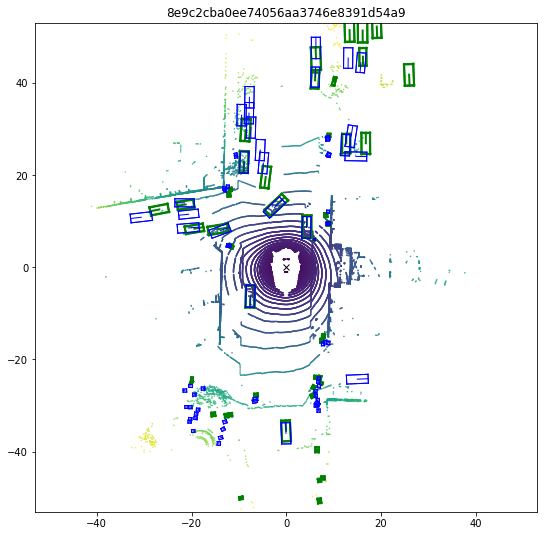

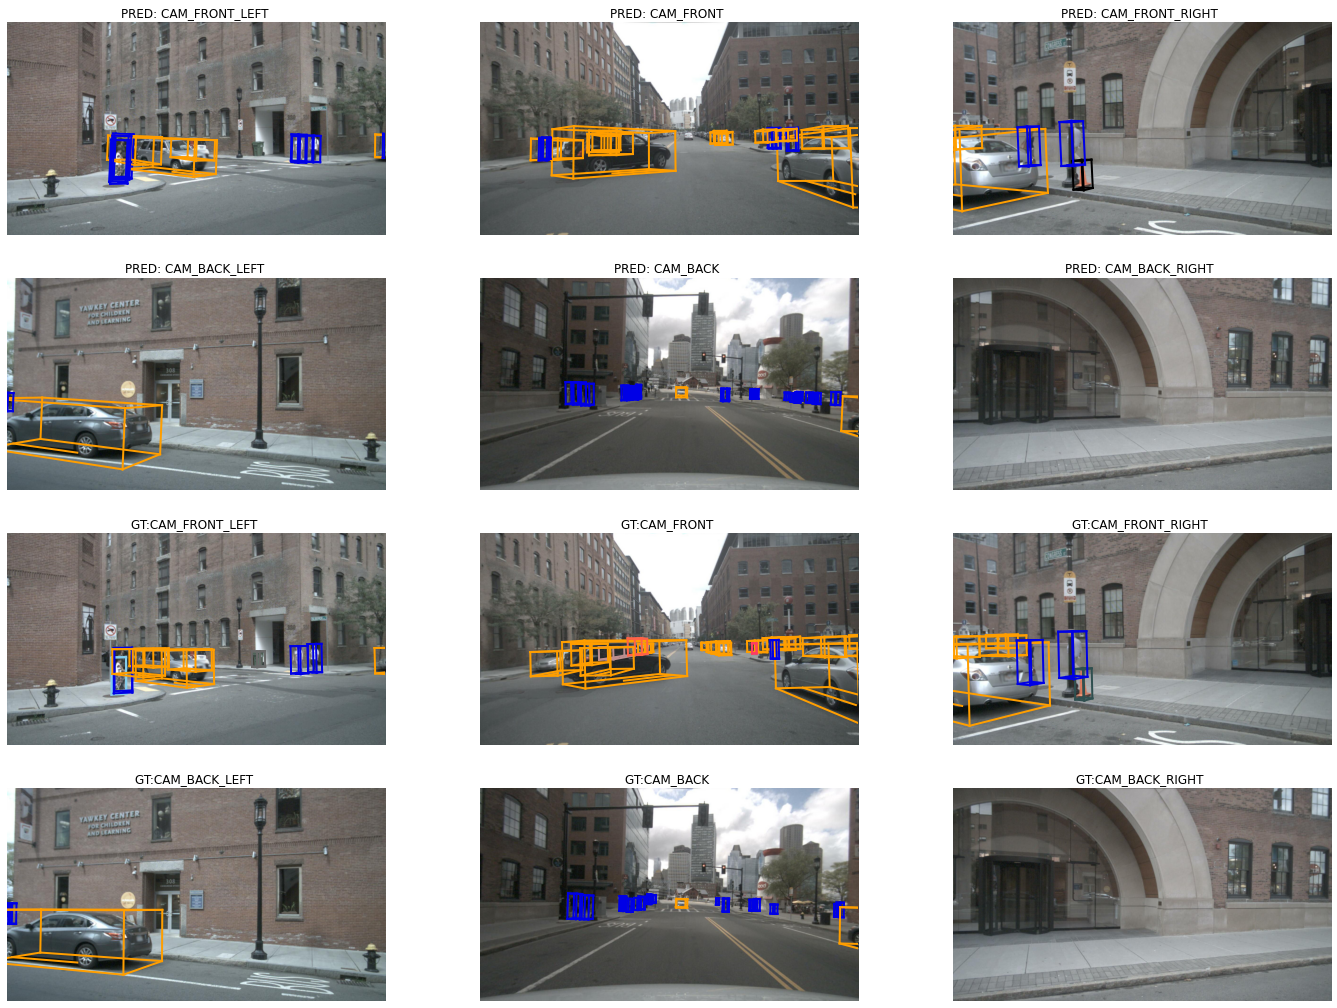

In [17]:
import json
bevformer = '/home/lzq/bevformer/test/bevformer_r101_200x200_deformable_8p_fp16_video2/Mon_Dec_20_09_00_22_2021/pts_bbox/results_nusc.json'
#detr3d = '/home/lzq/workspace/bev/bevformer/test/detr3d_res101_gridmask/Tue_Dec_14_14_14_59_2021/pts_bbox/results_nusc.json'
data1 = json.load(open(bevformer,'r'))
#data2 = json.load(open(detr3d,'r'))
sample_token_list1 = list(data1['results'].keys())
#sample_token_list2 = list(data2['results'].keys())
id = 17
render_sample_data(sample_token_list1[id],pred_data=data1)
#render_sample_data(sample_token_list2[id],pred_data=data2)